In [1]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix

Matplotlib is building the font cache; this may take a moment.


## Loading Dataset

In [6]:
import os
import pandas as pd

# Set the directory path where your image folders are located
directory_path = "skin images/"

# Create an empty list to store the data
data = []

# Loop through each folder and extract the file name and category
for folder in os.listdir(directory_path):
    if os.path.isdir(os.path.join(directory_path, folder)):
        for filename in os.listdir(os.path.join(directory_path, folder)):
            # Add the category name to the beginning of the file name
            new_filename = folder + '/' + filename
            # Append the file name and category to the data list
            data.append((new_filename, folder))

# Create the dataframe from the data list
df = pd.DataFrame(data, columns=["filename", "category"])

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'skin images/'

In [ ]:
df

,filename,category
0,dryskin_images/dry1 - Copy (2).webp,dryskin_images
1,dryskin_images/dry1 - Copy - Copy.webp,dryskin_images
2,dryskin_images/dry1 - Copy.webp,dryskin_images
3,dryskin_images/dry1.webp,dryskin_images
4,dryskin_images/dry10 - Copy (2).jpg,dryskin_images
...,...,...
831,skin_moles/skin_mole_29.jpeg,skin_moles
832,skin_moles/skin_mole_30 - Copy (2).jpeg,skin_moles
833,skin_moles/skin_mole_30 - Copy - Copy.jpeg,skin_moles
834,skin_moles/skin_mole_30 - Copy.jpeg,skin_moles


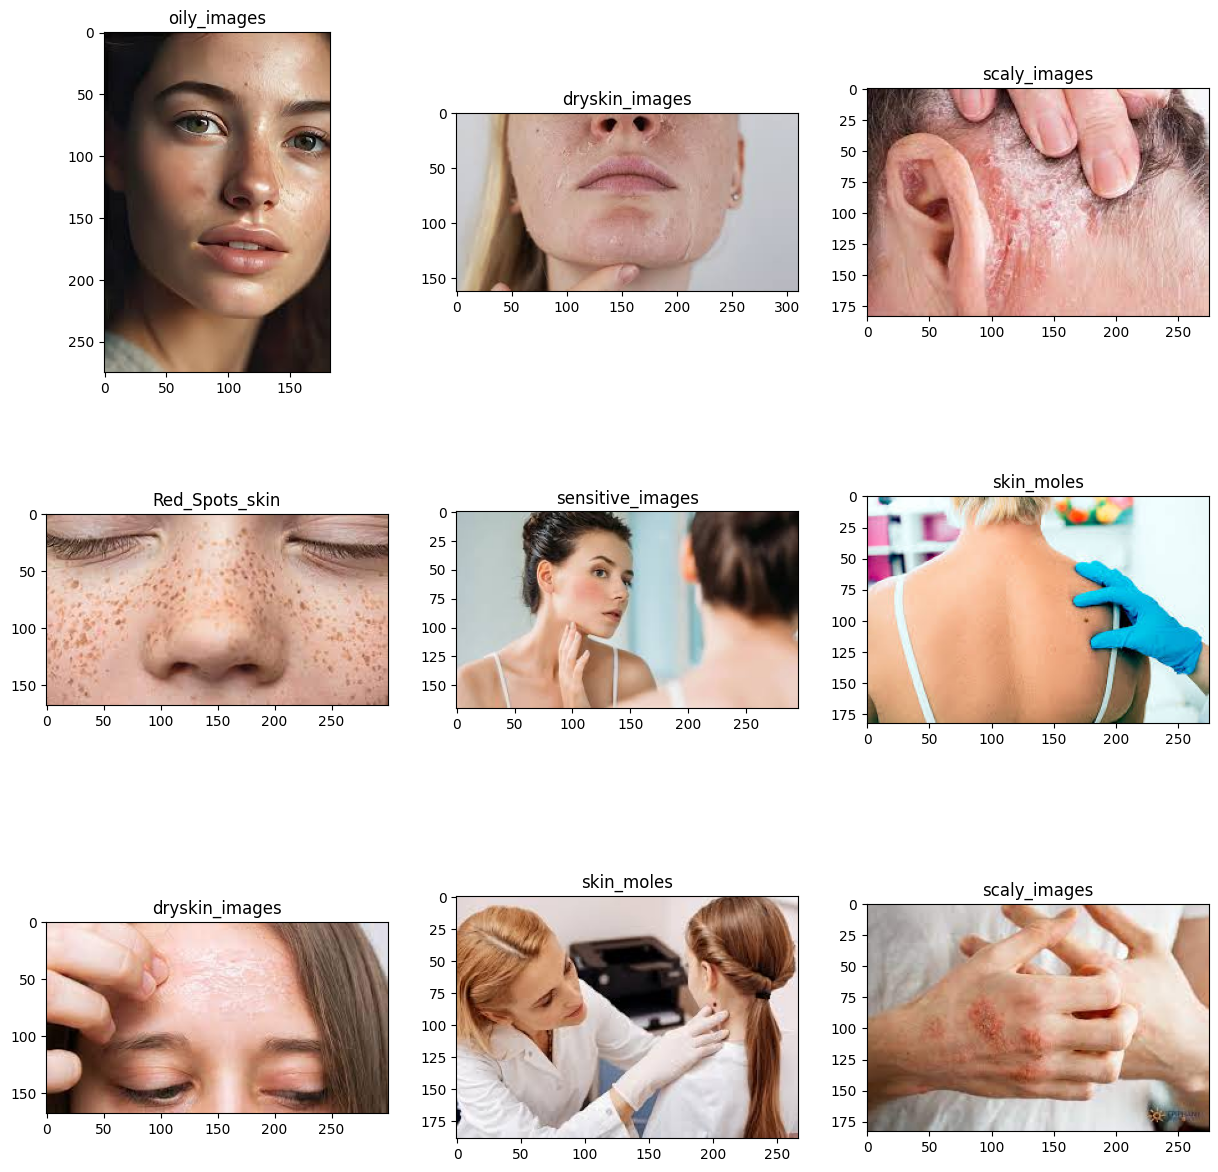

In [ ]:
from tensorflow.keras.preprocessing import image
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(directory_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

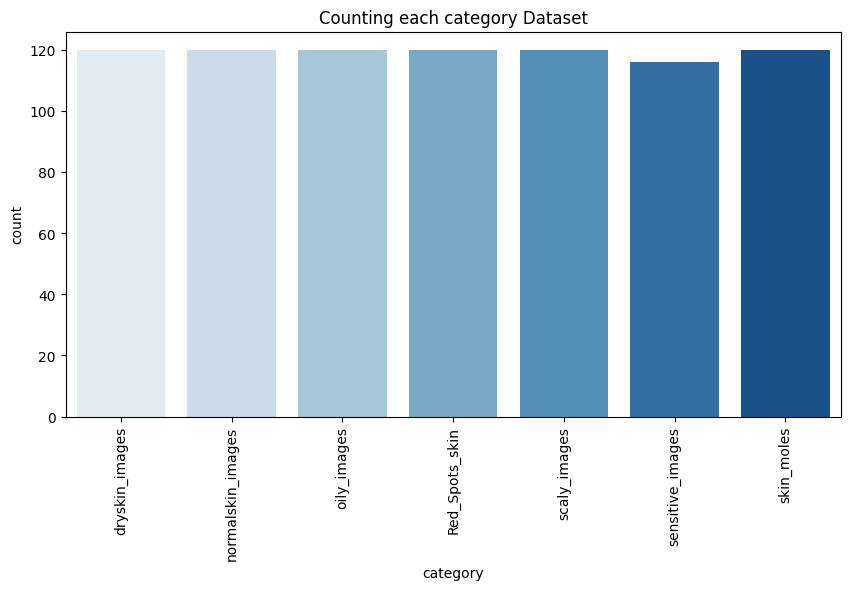

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Counting each category Dataset')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Split Data Into Train And Test

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(668, 84, 84)

In [ ]:
train_df.head()

,filename,category
0,oily_images/oily6 - Copy.jpg,oily_images
1,Red_Spots_skin/skin_rashes - Copy.jpeg,Red_Spots_skin
2,sensitive_images/sensitive30.jpg,sensitive_images
3,oily_images/oily23 - Copy.jpg,oily_images
4,skin_moles/skin_mole_12.jpeg,skin_moles


### Data Pre-Processing

In [ ]:
im_shape = (224, 224)
batch_size = 8
seed = 42

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 630 validated image filenames belonging to 7 classes.


c:\Users\DELL\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 38 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=directory_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 78 validated image filenames belonging to 7 classes.


c:\Users\DELL\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=directory_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 84 validated image filenames belonging to 7 classes.


In [ ]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['Red_Spots_skin', 'dryskin_images', 'normalskin_images', 'oily_images', 'scaly_images', 'sensitive_images', 'skin_moles']


##  CNN

### Creating Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
epochs = 10

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
78/78 [==============================] - ETA: 0s - loss: 1.9567 - accuracy: 0.1672
Epoch 00001: val_loss improved from inf to 1.96578, saving model to model.h5
78/78 [==============================] - 86s 1s/step - loss: 1.9567 - accuracy: 0.1672 - val_loss: 1.9658 - val_accuracy: 0.1250
Epoch 2/10
78/78 [==============================] - ETA: 0s - loss: 1.9404 - accuracy: 0.1704
Epoch 00002: val_loss improved from 1.96578 to 1.95208, saving model to model.h5
78/78 [==============================] - 89s 1s/step - loss: 1.9404 - accuracy: 0.1704 - val_loss: 1.9521 - val_accuracy: 0.0972
Epoch 3/10
78/78 [==============================] - ETA: 0s - loss: 1.9433 - accuracy: 0.1543
Epoch 00003: val_loss did not improve from 1.95208
78/78 [==============================] - 90s 1s/step - loss: 1.9433 - accuracy: 0.1543 - val_loss: 1.9571 - val_accuracy: 0.1111
Epoch 4/10
78/78 [==============================] - ETA: 0s - loss: 1.9426 - accuracy: 0.1383
Epoch 00004: val_loss did no

### plotting 

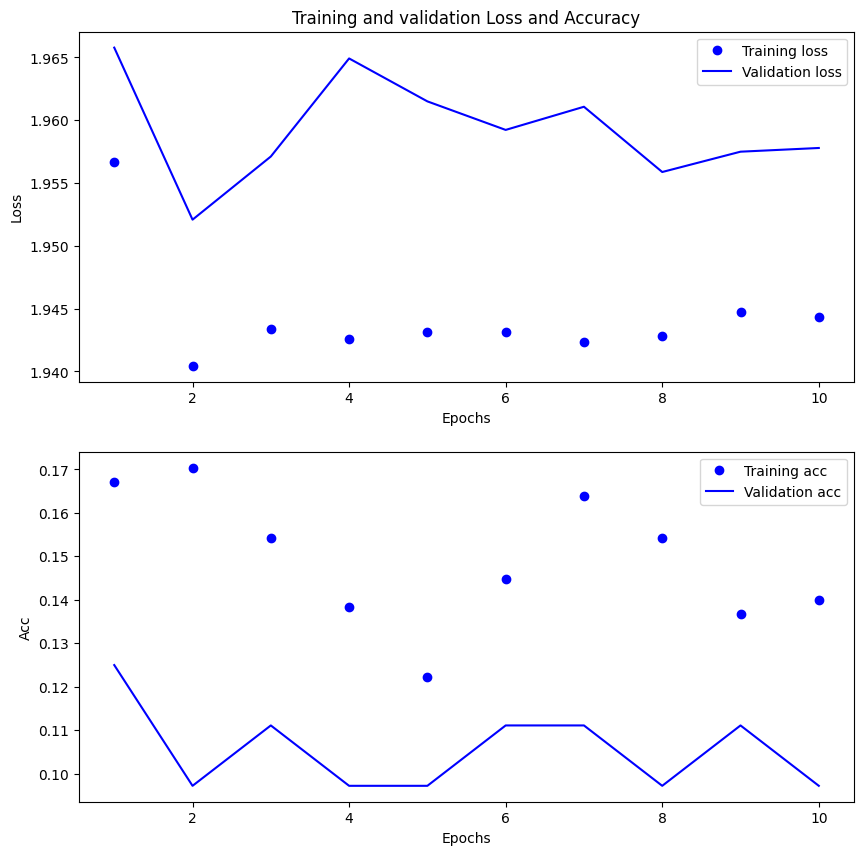

In [ ]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
model = load_model('model.h5')

In [ ]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

10/10 [==============================] - 2s 225ms/step - loss: 1.9598 - accuracy: 0.1026
Val loss: 1.9598373174667358
Val accuracy: 0.10256410390138626


In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

84/84 [==============================] - 4s 49ms/step - loss: 1.9452 - accuracy: 0.0952
Test loss: 1.9451502561569214
Test accuracy: 0.095238097012043


### Model evaluation

Classification Report
                   precision    recall  f1-score   support

   Red_Spots_skin       0.00      0.00      0.00        13
   dryskin_images       0.00      0.00      0.00        10
normalskin_images       0.10      1.00      0.17         8
      oily_images       0.00      0.00      0.00         8
     scaly_images       0.00      0.00      0.00        13
 sensitive_images       0.00      0.00      0.00        15
       skin_moles       0.00      0.00      0.00        17

         accuracy                           0.10        84
        macro avg       0.01      0.14      0.02        84
     weighted avg       0.01      0.10      0.02        84



c:\Users\DELL\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

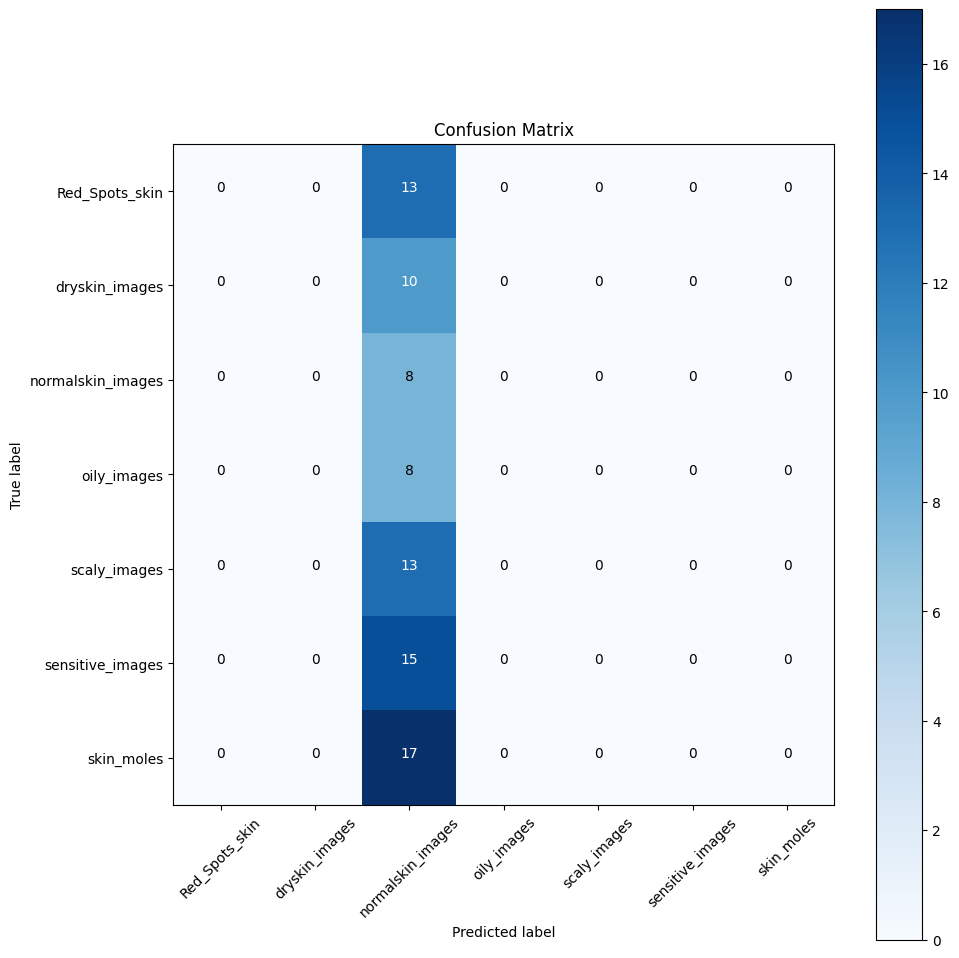

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
img = image.load_img(r'skin images\dryskin_images\dry1 - Copy - Copy.webp')
y = image.img_to_array(img)
y = np.expand_dims(y, axis=0)

In [ ]:
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 320, 240

# load the model we saved
model = load_model("model.h5")
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img(r'skin_images\dry1 - Copy - Copy.webp', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print(classes)

# predicting multiple images at once
img = image.load_img(r'skin images\oily_images\oily1 - Copy - Copy.jpg', target_size=(img_width, img_height))
y = image.img_to_array(img)
y = np.expand_dims(y, axis=0)

# pass the list of multiple images np.vstack()
images = np.vstack([x, y])
classes = model.predict_classes(images, batch_size=10)

# print the classes, the images belong to
print(classes)
print(classes[0])
print(classes[0][0])

FileNotFoundError: [Errno 2] No such file or directory: 'skin_images\\dry1 - Copy - Copy.webp'

In [ ]:
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 320, 240

# load the model we saved
model = load_model("modelpp.h5")
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


OSError: No file or directory found at modelpp.h5

In [ ]:
# predicting images
img = image.load_img(r'D:\AVRP\New folder (3)\skin\skin\skin images\dryskin_images\dry1 - Copy - Copy.webp', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)


In [ ]:

images = np.vstack([x])
classes = model.predict_classes(img, batch_size=10)
print(classes)

NameError: name 'x' is not defined

In [ ]:
model = tf.keras.Sequential([
  tf.keras.Input(shape=(28,28)),
  tf.keras.layers.GRU(128),
  tf.keras.layers.Dense(128, activation='relu',input_shape=(28, 28, )),
  tf.keras.layers.Dropout(0.2,input_shape=(128,)),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
def scheduler(epoch, lr):
      if epoch < 8:
        return lr
      else:
        return lr * tf.math.exp(-0.1)
      
      

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=2),
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]
trainer=model.fit(train_images, train_labels,validation_data=(test_images,test_labels), epochs=20,callbacks=my_callbacks)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
# Resizinig all the images to (224,224)
IMAGE_SIZE = [128,128]

train_path = 'Skin_TypesTrain'
test_path = 'Skin_Types/Test'

In [ ]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)